# Test on synthetic data

We evaluate the performance of the gridder on synthetic data produced by a visco-elastic model of the San Andreas Fault. We extract samples from the model grid and try to reconstruct the original grid using our interpolation method.

In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dask.distributed import Client, LocalCluster
from scipy.spatial import cKDTree
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import verde as vd
# Load our custom gridder and utility functions
from vectorspline3d import VectorSpline3D
from vectorspline3d.utils import sample_from_grid, DummyGridder

## Load the 3-component synthetic grid

The synthetic grid is stored in a netCDF file with all 3 components included. This grid is a subsection of the original model data.

In [2]:
grid = xr.open_dataset("../../data/synthetic-san-andreas-2017.nc")
grid.up_velocity.values *= -1
mask = xr.open_dataset("../../data/synthetic-landmask.nc")
print(grid)

<xarray.Dataset>
Dimensions:         (latitude: 251, longitude: 401)
Coordinates:
  * latitude        (latitude) float64 33.0 33.02 33.04 ... 37.96 37.98 38.0
  * longitude       (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0
Data variables:
    east_velocity   (latitude, longitude) float64 ...
    north_velocity  (latitude, longitude) float64 ...
    up_velocity     (latitude, longitude) float64 nan nan ... 0.02379 0.02325
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        evel_2017.grd
    history:      grdsample vjunk.grd -Gevel_2017.grd -T
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1


Extract some useful values from the grid, like grid spacing, region, and coordinates. We'll use these values later on.

In [3]:
region = vd.get_region((grid.longitude.values, grid.latitude.values))
spacing = 0.02
print(region)

(-123.0, -115.0, 33.0, 38.0)


Create a function that plots our grid with vectors for the horizontal components and a pseudo-color map for the vertical.

In [4]:
def plot_data(data, ax=None, maxabs=3, every_arrow=8, quiver_scale=250, quiver_width=0.001, size=50):
    "Plot a grid or a DataFrame with the vertical in color and horizontal as vectors."
    crs = ccrs.Mercator()
    transform = ccrs.PlateCarree()
    if ax is None:
        plt.figure(figsize=(12, 14))
        ax = plt.subplot(111, projection=crs)
    #ax.add_feature(cfeature.GSHHSFeature(), facecolor="gray", zorder=-1)
    #ax.add_feature(cfeature.OCEAN, faceco)lor="skyblue")
    cbargs = dict(orientation="horizontal", aspect=50, pad=0.03, label="vertical velocity (mm/yr)",
                  shrink=0.8)
    if isinstance(data, pd.DataFrame):
        tmp = ax.scatter(
            data.longitude, data.latitude, s=size, c=data.up_velocity,
            vmin=-maxabs, vmax=maxabs, cmap="seismic", transform=transform
        )
        plt.colorbar(tmp, ax=ax, **cbargs)        
    else:
        data.up_velocity.plot.pcolormesh(
            ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic", cbar_kwargs=cbargs, 
            add_labels=False, transform=transform
        )
        indexer = slice(None, None, every_arrow)
        # Downsample the arrows so we can actually see something
        data = data.isel(longitude=indexer, latitude=indexer)
    ax.quiver(data.longitude.values, data.latitude.values, 
              data.east_velocity.values, data.north_velocity.values, 
              scale=quiver_scale, width=quiver_width, transform=transform)
    ax.coastlines(resolution="50m", linewidth=1)
    # Set the proper ticks for a Cartopy map
    ax.set_xticks(np.arange(*region[:2], 1), crs=transform)
    ax.set_yticks(np.arange(*region[2:], 1), crs=transform)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_extent(region, crs=transform)
    return ax

Plot the synthetic grid.

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


Text(0.5, 1.0, 'Synthetic data')

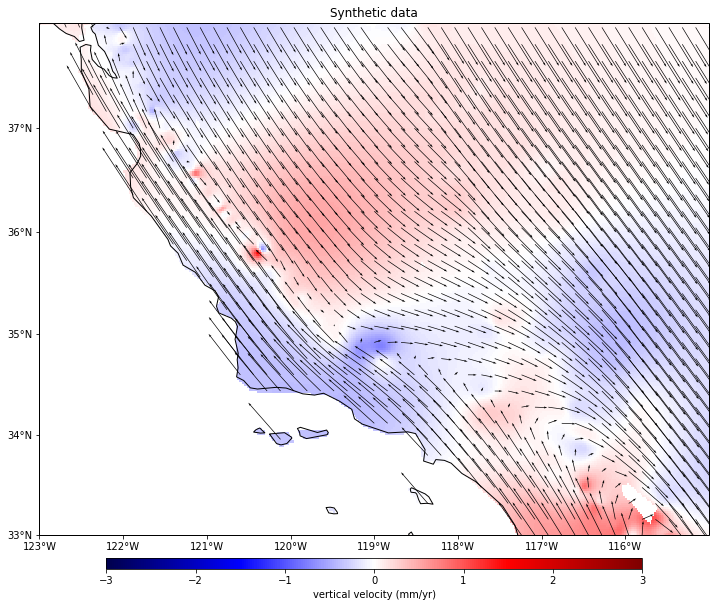

In [5]:
ax = plot_data(grid)
ax.set_title("Synthetic data")

## Extract samples

We'll test our gridder on samples extracted from the synthetic grid. We'll use the station locations for the actual PBO data as extration points.

In [6]:
pbo_coords = pd.read_csv(
    "../../data/pbo.final_nam08.vel", 
    skiprows=36, 
    usecols=[7, 8], 
    delim_whitespace=True
).values.T[::-1]
pbo_coords[0] -= 360
inside = vd.inside(pbo_coords, region)
pbo_coords = tuple(coord[inside] for coord in pbo_coords)

Extract sample from the grid.

In [7]:
data = sample_from_grid(
    grid, 
    coordinates=dict(longitude=pbo_coords[0], latitude=pbo_coords[1])
)
data = data.dropna()
print(data.shape)
ndata = data.shape[0]
data.head()

(1769, 5)


,east_velocity,north_velocity,up_velocity,longitude,latitude
0,1.183206,2.223193,0.072251,-117.1,34.12
1,1.183206,2.223193,0.072251,-117.1,34.12
2,1.183206,2.223193,0.072251,-117.1,34.12
3,1.183206,2.223193,0.072251,-117.1,34.12
4,1.183206,2.223193,0.072251,-117.1,34.12


Text(0.5, 1.0, 'Synthetic samples')

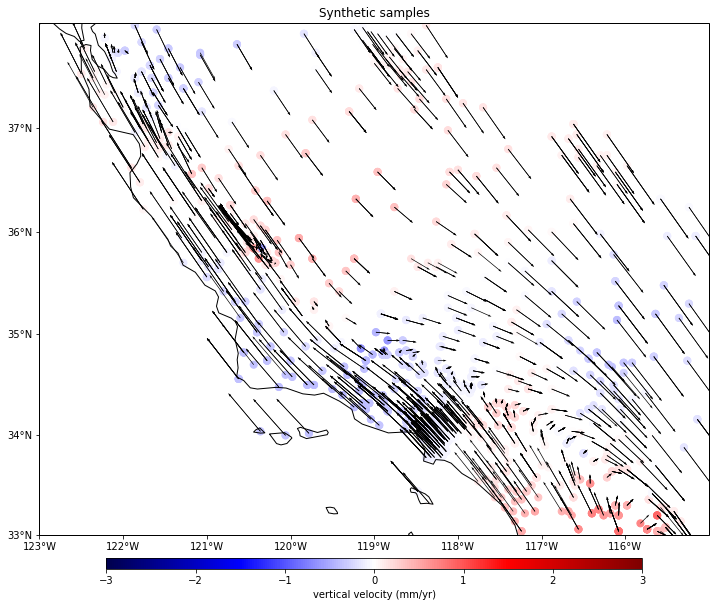

In [8]:
plot_data(data).set_title("Synthetic samples")

## Fit the 3 component spline

We'll do a grid-search for the best configuration by optimizing the R² score on the original gridded data.

The gridder only operates on Cartesian data so we'll need to project the data coordinates before gridding.

In [9]:
coordinates = (data.longitude.values, data.latitude.values)
components = (data.east_velocity, data.north_velocity, data.up_velocity)

projection = pyproj.Proj(proj="merc", lon_0=data.longitude.mean())
proj_coords = projection(*coordinates)

A challenge is where to place the forces. Traditionally, forces are placed beneath each data point. This can lead to aliasing unless the data is first decimated using a blocked mean/median. What we can do instead is to use a blocked mean to determine force positions and number and keep the full dataset for fitting. The spacing for the blocked mean is the final desired spacing for our grid.

In [10]:
blockmean = vd.BlockReduce(reduction=np.mean, spacing=spacing*111e3)
force_coords, _ = blockmean.filter(proj_coords, np.ones(ndata))

In [11]:
tree = cKDTree(np.transpose(proj_coords))
nn_distance = np.median(tree.query(np.transpose(force_coords), k=20)[0], axis=1)

(-480775.10488293186, 420467.50330201176, 3843670.025348158, 4583952.263993728)

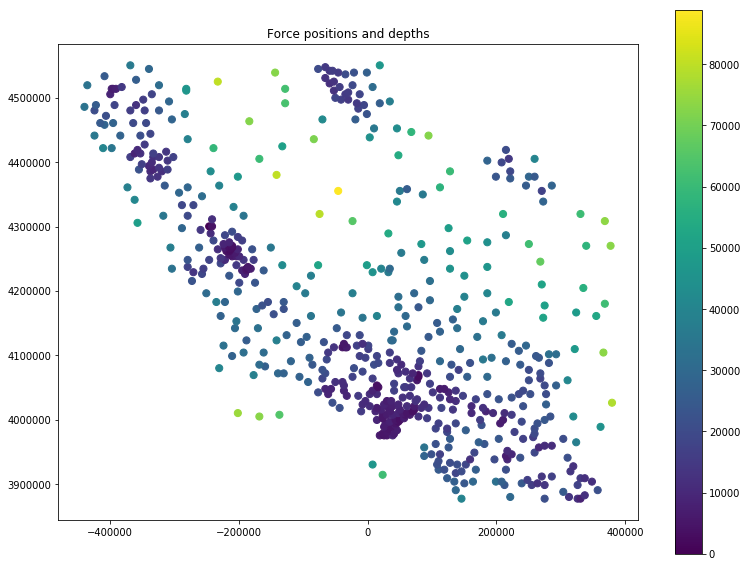

In [12]:
plt.figure(figsize=(13, 10))
plt.title("Force positions and depths")
plt.scatter(*force_coords, s=50, c=nn_distance)
plt.colorbar()
plt.axis("scaled")

Another issue is with the different magnitudes of each data component.

In [13]:
print(np.linalg.norm(data.up_velocity)/np.linalg.norm(data.east_velocity))

0.025740111323276797


This means that an unweighted fit will favor the horizontal components at the expense of the vertical. We can use data weights to balance things out and make sure that the vertical is fitted as well.

In [27]:
weights = tuple(np.full(data.shape[0], w, dtype="float32") for w in [0.001, 0.001, 1])

Our training data set will be randomly sampled set and the testing set will be original grid data.

In [28]:
train = (
    proj_coords, 
    components, 
    weights
)
test_data = vd.grid_to_table(grid).dropna()
test = (
    projection(test_data.longitude.values, test_data.latitude.values),
    (test_data.east_velocity, test_data.north_velocity, test_data.up_velocity)
)

This is a time consuming process and each step doesn't require that much memory. So we can run the grid search in parallel using Dask. We'll create a Dask client that uses a local cluster (running on this machine).

In [16]:
client = Client(LocalCluster(n_workers=4))
client

Client Scheduler: tcp://127.0.0.1:43225 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.70 GB


Since the train and test data are the same for each step, we can scatter them across the cluster once to avoid the transfer costs at every job.

In [29]:
train_future = client.scatter(train)
test_future = client.scatter(test)

In [30]:
def fit_score(estimator, train, test):
    return estimator.fit(*train).score(*test)

This is the parameter grid that we'll use to search for optimal configuration.

In [42]:
dampings = [0.1, 0.5, 1, 2, 3, 4, 5, 10]
depths = [1e3, 5e3, 10e3, 15e3, 20e3, 30e3, 40e3, 50e3]
poissons = [-1, -0.5, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

#dampings = [1]
#depths = [15e3]
#poissons = [0.5]

# Use itertools to create a list with all combinations of parameters to test
parameters = list(itertools.product(dampings, depths, poissons))
print("Number of combinations:", len(parameters))

Number of combinations: 512


Now we can fit and score a gridder for each parameter combination and gather the R² scores.


In [ ]:
%%time
scores = []
for damping, depth, poisson in parameters:
    candidate = vd.Chain([    
        ("trend", vd.Vector([vd.Trend(degree=2), vd.Trend(degree=2), DummyGridder()])), 
        ("spline", VectorSpline3D(poisson=poisson, depth=depth + nn_distance, 
                                  damping=damping, force_coords=force_coords)),
    ])    
    scores.append(client.submit(fit_score, candidate, train_future, test_future))
scores = [i.result() for i in scores]
best = np.argmax(scores)
best_parameters = dict(
    damping=parameters[best][0], 
    depth=parameters[best][1], 
    poisson=parameters[best][2], 
)
print("Best score on testing set:", scores[best])
print("Best parameters:", best_parameters)

Fit the spline on the test configuration and score it on the training data to see how well it fit.

In [38]:
%%time
best_parameters["depth"] += nn_distance
spline = vd.Chain([
    ("trend", vd.Vector([vd.Trend(degree=2), vd.Trend(degree=2), DummyGridder()])), 
    ("spline", VectorSpline3D(force_coords=force_coords, **best_parameters))
])
spline.fit(*train)
print("Score on training set:", spline.score(*train))

Score on training set: 0.9674761922293514
CPU times: user 2.32 s, sys: 741 ms, total: 3.06 s
Wall time: 654 ms


## Regenerate the original grid

Now we can recreate the original grid and calculate and plot the differences.

In [39]:
grid_spl = spline.grid(
    region=region,
    spacing=spacing, 
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
).where(mask.z.values)
grid_spl = vd.distance_mask(coordinates, maxdist=50e3, grid=grid_spl, projection=projection)

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


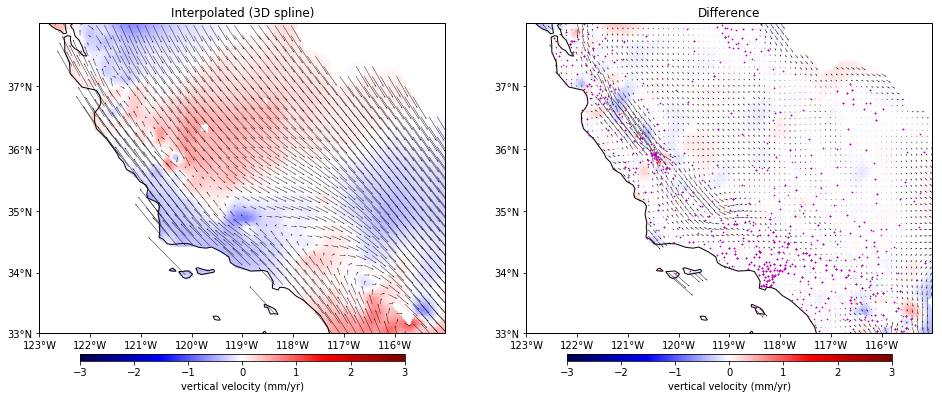

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 13), subplot_kw=dict(projection=ccrs.Mercator()))
plot_data(grid_spl, ax=axes[0]).set_title("Interpolated (3D spline)")
plot_data(grid - grid_spl, ax=axes[1], every_arrow=5).set_title("Difference")
axes[1].plot(data.longitude, data.latitude, "m.", transform=ccrs.PlateCarree(), markersize=1)

Notice that the biggest difference is along the fault where there is a sharper variation on the velocity. The region with denser data coverage is less affected by this, as expected.

## Compare with other methods

We'll compare the performance of our method using 3 single-component splines.

In [24]:
%%time
dampings = [None, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2]
mindists = [100e3]

parameters = list(itertools.product(dampings, mindists))

scores_bi = []
for damping, mindist in parameters:
    candidate = vd.Vector([
        vd.Spline(damping=damping, mindist=mindist, force_coords=force_coords)
        for i in range(3)
    ])
    scores_bi.append(client.submit(fit_score, candidate, train_future[:2], test_future))
scores_bi = [i.result() for i in scores_bi]
best = np.argmax(scores_bi)
best_parameters_bi = dict(
    damping=parameters[best][0], 
    mindist=parameters[best][1], 
)
print("Best score on testing set:", scores_bi[best])
print("Best parameters:", best_parameters_bi)

Best score on testing set: 0.9798102321721456
Best parameters: {'damping': None, 'mindist': 100000.0}
CPU times: user 769 ms, sys: 76.7 ms, total: 846 ms
Wall time: 8.51 s


In [25]:
%%time
spline_bi = vd.Vector([
        vd.Spline(force_coords=force_coords, **best_parameters_bi)
        for i in range(3)
]).fit(*train[:2])
print("Score on training set:", spline_bi.score(*train))

Score on training set: 1.0
CPU times: user 4.57 s, sys: 3 s, total: 7.56 s
Wall time: 2.32 s


In [26]:
grid_spl_bi = spline_bi.grid(
    region=region,
    spacing=spacing, 
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
).where(mask.z.values)
grid_spl_bi = vd.distance_mask(coordinates, maxdist=50e3, grid=grid_spl_bi, projection=projection)

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


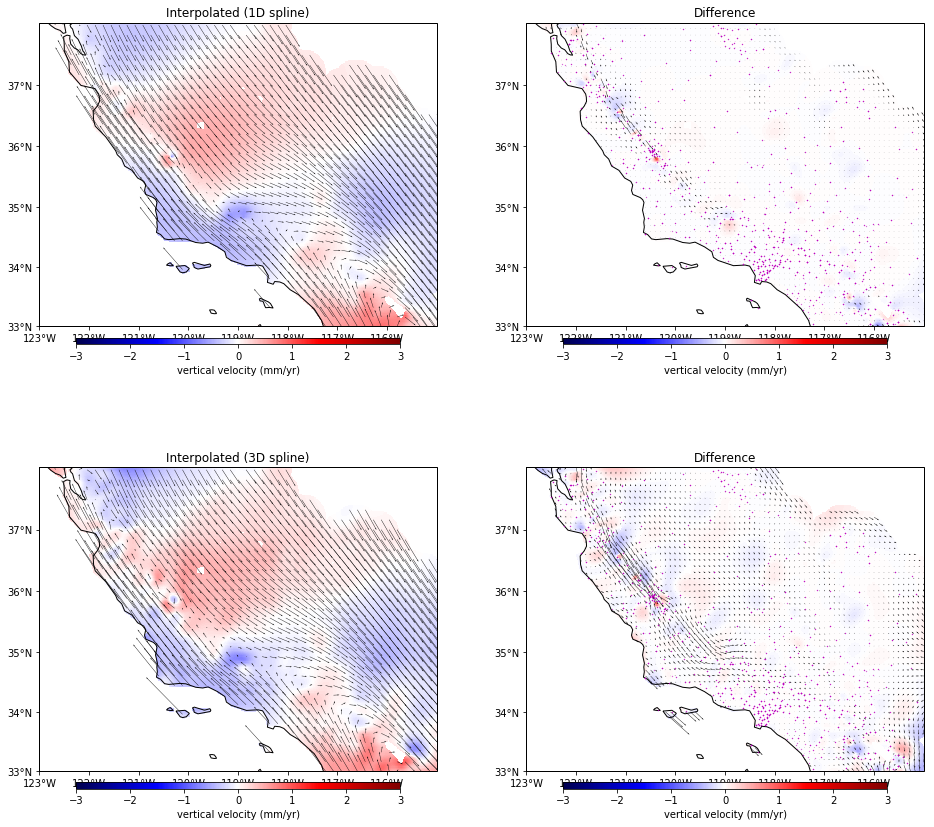

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 15), subplot_kw=dict(projection=ccrs.Mercator()))
axes = axes.ravel()
plot_data(grid_spl_bi, ax=axes[0]).set_title("Interpolated (1D spline)")
plot_data(grid - grid_spl_bi, ax=axes[1], every_arrow=5).set_title("Difference")
axes[1].plot(data.longitude, data.latitude, "m.", transform=ccrs.PlateCarree(), markersize=0.5)

plot_data(grid_spl, ax=axes[2]).set_title("Interpolated (3D spline)")
plot_data(grid - grid_spl, ax=axes[3], every_arrow=5).set_title("Difference")
axes[3].plot(data.longitude, data.latitude, "m.", transform=ccrs.PlateCarree(), markersize=0.5)